In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from ultralytics.data.dataset import YOLODataset
from ultralytics.data.augment import BaseTransform
from ultralytics.models.yolo.detect import DetectionTrainer  
from ultralytics.utils import YAML  
from ultralytics import YOLO
from ultralytics.utils.instance import Instances  
from ultralytics.utils.ops import xywhn2xyxy
from PIL import Image
import cv2
from glob import glob
import torch
import torch.nn as nn
import os, shutil

(720, 1280, 3)


Text(0.5, 1.0, 'Resized')

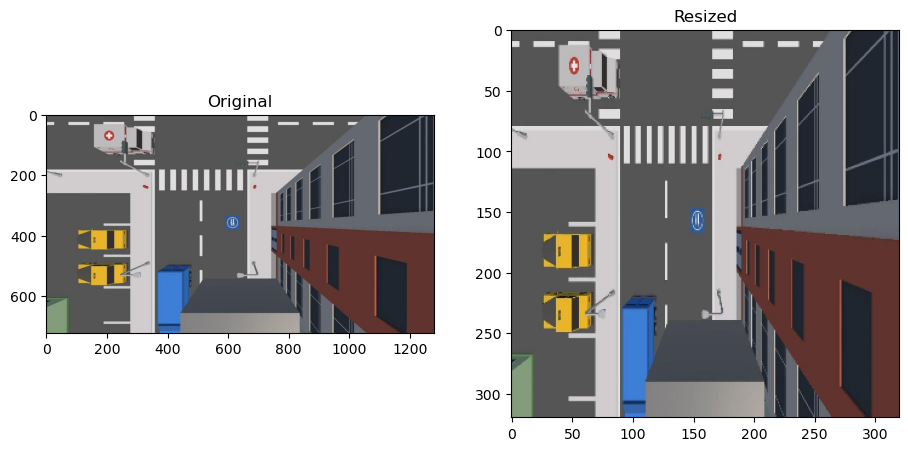

In [2]:
images = glob("./data/train/images/*.jpg")
img = cv2.imread(images[20])

size = 320
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized = cv2.resize(img, (size, size))

print(img.shape)

plt.figure(figsize=(11, 12))

plt.subplot(121)
plt.imshow(img)
plt.title("Original")

plt.subplot(122)
plt.imshow(resized)
plt.title("Resized")

Fast image access  (ping: 0.10.0 ms, read: 90.338.2 MB/s, size: 60.9 KB)
Scanning data\train\labels... 210 images, 87 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 210/210 1.9Kit/s 0.1s<0.0s
New cache created: data\train\labels.cache


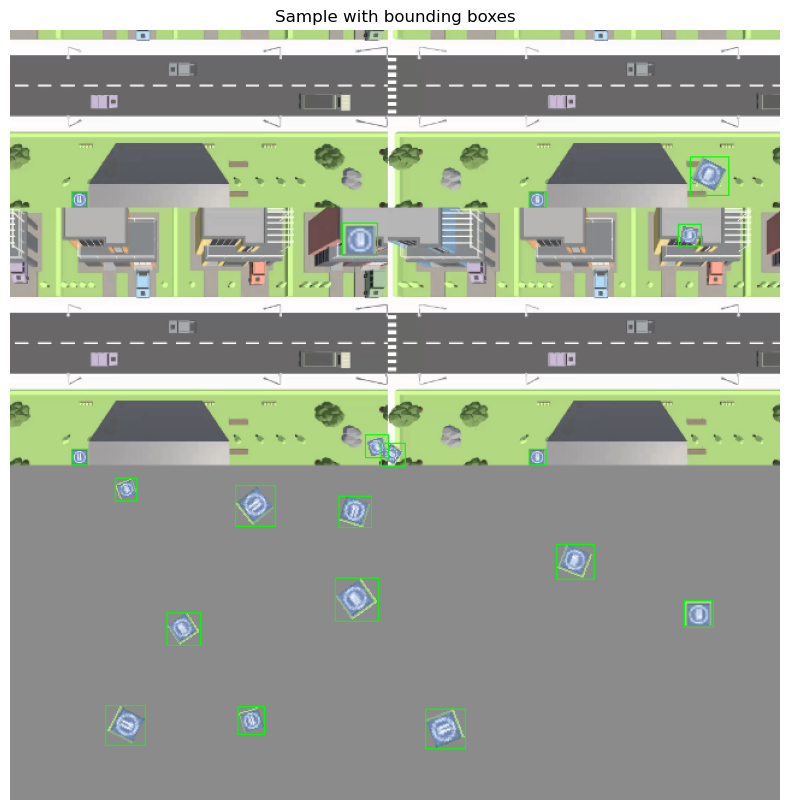

In [ ]:
np.random.seed(42)


def paste_flag_on_img(img, bbox) -> tuple[int, int, int, int, np.ndarray]:
    """Returns x1, y1, x2, y2, img"""
    scale = np.random.uniform(0.9, 2)
    theta = np.random.uniform(0, 360)

    x1, y1, x2, y2 = bbox.astype(int)
    img_h, img_w = img.shape[:2]

    # Get new position
    flag_img = img[y1:y2, x1:x2].copy()
    w_new, h_new = int((x2 - x1) * scale), int((y2 - y1) * scale)
    paste_x = np.random.randint(0, img_w - w_new)
    paste_y = np.random.randint(0, img_h - h_new)

    flag_img_pil = Image.fromarray(flag_img).convert("RGBA")
    img_pil = Image.fromarray(img)

    # Augment flag
    flag_img_pil = flag_img_pil.resize((w_new, h_new))
    flag_img_pil = flag_img_pil.rotate(angle=theta, expand=True)
    img_pil.paste(flag_img_pil, (paste_x, paste_y), mask=flag_img_pil)
    
    x1 = paste_x
    x2 = paste_x + flag_img_pil.size[0]
    y1 = paste_y
    y2 = paste_y + flag_img_pil.size[1]

    return x1, y1, x2, y2, np.array(img_pil)


def get_new_instances(new_bboxes, instances):
    new_bboxes = np.array(new_bboxes, dtype=np.float32)

    num_new = len(new_bboxes)
    if len(instances.segments) > 0:
        seg_len = instances.segments.shape[1]
        new_segments = np.zeros((num_new, seg_len, 2), dtype=np.float32)
    else:
        new_segments = np.zeros((num_new, 1000, 2), dtype=np.float32)

    new_instances = Instances(new_bboxes, segments=new_segments, bbox_format="xyxy", normalized=False)
    return new_instances


class DuplicateTransform(BaseTransform):
    def __init__(self, n_objs=15, p=1):
        super().__init__()
        self.n_objs = n_objs
        self.p = p

    def __call__(self, labels):
        img = labels["img"]  # H x W x C
        instances = labels["instances"]
        instances.convert_bbox(format="xyxy")
        classes = labels["cls"]

        if np.random.rand() > self.p or len(instances) <= 0:
            return labels

        new_bboxes = []
        new_classes = []

        for _ in range(self.n_objs):
            rand_idx = np.random.randint(0, len(instances))
            bbox = instances.bboxes[rand_idx]

            x1_new, y1_new, x2_new, y2_new, img = paste_flag_on_img(img, bbox)

            new_bboxes.append([x1_new, y1_new, x2_new, y2_new])
            new_classes.append(classes[rand_idx])

        labels['img'] = img
        # Update labels with new instances
        if len(new_bboxes) > 0:
            new_instances = get_new_instances(new_bboxes, instances)

            labels["instances"] = Instances.concatenate([instances, new_instances], axis=0)
            labels["cls"] = np.concatenate([classes, np.array(new_classes)], axis=0)

        return labels


class CustomYOLODataset(YOLODataset):
    """Custom dataset with our test transform."""

    def build_transforms(self, hyp=None):
        """Override to add our custom transform."""
        transforms = super().build_transforms(hyp)
        transforms.transforms.insert(-1, DuplicateTransform())

        return transforms


data_dict = YAML.load("./data/data.yaml")
dataset = CustomYOLODataset(
    img_path="./data/train/images",
    data=data_dict,
    imgsz=640,
    augment=True,  # Enable augmentations to see your transform
    task="detect",  # Specify your task
)

sample = dataset[np.random.randint(0, len(dataset))]

img = sample["img"].permute(1, 2, 0).numpy()
img = np.ascontiguousarray(img)
bboxes = sample["bboxes"]  # normalized xywh format
h, w = img.shape[:2]

# Draw bounding boxes
for bbox in bboxes:
    x_center, y_center, width, height = bbox
    # Convert normalized to pixel coordinates
    x1 = int((x_center - width / 2) * w)
    y1 = int((y_center - height / 2) * h)
    x2 = int((x_center + width / 2) * w)
    y2 = int((y_center + height / 2) * h)

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display
plt.figure(figsize=(10, 10))
plt.imshow(img[..., ::-1])
plt.title(f"Sample with bounding boxes")
plt.axis("off")
plt.show()

In [7]:
class CustomTrainer(DetectionTrainer):
    """Custom trainer that uses our CustomYOLODataset."""

    def build_dataset(self, img_path, mode="train", batch=None):
        """Build dataset using our custom class."""
        gs = max(int(self.model.stride.max() if self.model else 0), 32)
        return CustomYOLODataset(
            img_path=img_path,
            imgsz=self.args.imgsz,
            batch_size=batch,
            augment=mode == "train",
            hyp=self.args,
            rect=mode == "val",
            cache=self.args.cache or None,
            single_cls=self.args.single_cls or False,
            stride=int(gs),
            pad=0.0 if mode == "train" else 0.5,
            prefix=f"{mode}: ",
            task=self.args.task,
            classes=self.args.classes,
            data=self.data,
            fraction=self.args.fraction if mode == "train" else 1.0,
        )


# model = YOLO("yolo11n.pt")
model = YOLO("./runs/detect/train12/weights/best.pt")

# Train using custom trainer
results = model.train(
    data="./data/data.yaml",
    epochs=23,
    imgsz=600,
    trainer=CustomTrainer,
    fliplr=0.5,
    flipud=0.5,
    hsv_h=0.15,
    hsv_s=0.45,
    hsv_v=0.68,
)

New https://pypi.org/project/ultralytics/8.3.228 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.225  Python-3.10.19 torch-2.9.0+cpu CPU (11th Gen Intel Core i7-1165G7 @ 2.80GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./data/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=23, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.15, hsv_s=0.45, hsv_v=0.68, imgsz=600, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=./runs/detect/train12/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train13

In [3]:
trained_model = YOLO('./runs/detect/train13/weights/best.pt')
trained_model.export(format='openvino')


Ultralytics 8.3.225  Python-3.10.19 torch-2.9.0+cpu CPU (11th Gen Intel Core i7-1165G7 @ 2.80GHz)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'runs\detect\train13\weights\best.pt' with input shape (1, 3, 608, 608) BCHW and output shape(s) (1, 5, 7581) (5.2 MB)

OpenVINO: starting export with openvino 2025.3.0-19807-44526285f24-releases/2025/3...
OpenVINO: export success  3.9s, saved as 'runs\detect\train13\weights\best_openvino_model\' (10.2 MB)

Export complete (4.4s)
Results saved to C:\Users\zeyad\Desktop\Projects\DronePayloadDropping\AIServer\notebooks\runs\detect\train13\weights
Predict:         yolo predict task=detect model=runs\detect\train13\weights\best_openvino_model imgsz=608  
Validate:        yolo val task=detect model=runs\detect\train13\weights\best_openvino_model imgsz=608 data=./data/data.yaml  
Visualize:       https://netron.app


'runs\\detect\\train13\\weights\\best_openvino_model'